In [1]:
! pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.8 MB/s eta 0:00:00


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from vit_pytorch.simple_vit_3d import SimpleViT
from vit_pytorch.simple_vit_3d import posemb_sincos_3d
from einops import rearrange
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import glob
import time

In [3]:
vit_3d = SimpleViT(
    image_size = 128,          # image size
    frames = 16,               # number of frames
    image_patch_size = 16,     # image patch size
    frame_patch_size = 2,      # frame patch size
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)

#example input:
#video = torch.randn(4, 3, 16, 128, 128) # (batch, channels, frames, height, width)

#embedding size will be (4, 1000)
#preds = vit_3d(video) # (4, 1000)

In [4]:
#source code for these conv block implemenations is from this UNETR implementation: https://github.com/tamasino52/UNETR/blob/main/unetr.py#L231
class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [43]:
class SimpleViT3dSeg(SimpleViT):
  #add decoder attributes for segmentation
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    print(kwargs['dim'], kwargs['num_classes'])
    #upsampling decoder, from patch size 8x8x8 to 128x128x128
    self.decoder = nn.Sequential(
      Deconv3DBlock(kwargs['dim'], 256),
      Deconv3DBlock(256, 128),
      Deconv3DBlock(128, 64),
      nn.Conv3d(in_channels=64, out_channels=kwargs['num_classes'], kernel_size=1)
    )

  #override the forward function so embeddings get fed into decoder instead of linear classification head
  def forward(self, video):
        *_, h, w, dtype = *video.shape, video.dtype

        x = self.to_patch_embedding(video)
        #print(f"patch shape: {x.shape}")
        _, depth_patch_size, height_patch_size, width_patch_size, _ = x.shape

        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        #print(f"raw embeddings shape: {x.shape}")
        batch_size, patch_volume, embd_size = x.shape

        #convert to per-patch embedding format for segmentation
        #credit: code for re-arranging to per-patch format generated from chatgpt
        feat_grid_embeddings = x.transpose(1, 2).contiguous().view(batch_size, embd_size, depth_patch_size, height_patch_size, width_patch_size)
        #print(f"per-patch embedding dim: {feat_grid_embeddings.shape}")

        #x = x.mean(dim = 1) #don't apply pooling since we want the per-patch embedding
        feat_grid_embeddings = self.to_latent(feat_grid_embeddings) #this is a palce holder, does nothing so we can keep it

        logits = self.decoder(feat_grid_embeddings)
        return logits

  def logits_to_mask(self, logits):
    return logits.argmax(dim=1)

In [44]:
test_vit_seg_model = SimpleViT3dSeg(
    image_size = 64,          # image size
    frames = 64,               # for volumetric data: this is slice number/depth
    image_patch_size = 8,     # image patch size
    frame_patch_size = 8,      # for volumetric data: this should be same as image patch size
    num_classes = 3,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

test_input = torch.randn(1, 3, 64, 64, 64)

preds = test_vit_seg_model(test_input)

print(preds.shape, type(preds))

1024 3
torch.Size([1, 3, 64, 64, 64]) <class 'torch.Tensor'>


In [45]:
#chatgpt generated using prompt "generate a simple function that generates a 3 channel white cube, inside it is a red sphere of varied position and radius"

def make_rgb_cube_with_red_sphere(T=64, H=64, W=64, cube_margin=8,
                                  min_radius=4, device="cpu"):
    """
    Returns:
      img:  (3, T, H, W) float32 in [0,1]
      mask: (T, H, W)    long: 0=bg, 1=cube, 2=sphere
    """
    # --- init ---
    img  = torch.zeros(3, T, H, W, dtype=torch.float32, device=device)  # RGB
    mask = torch.zeros(T, H, W, dtype=torch.long, device=device)        # seg labels

    # --- define cube bounds (axis-aligned) ---
    z0, z1 = cube_margin, T - cube_margin
    y0, y1 = cube_margin, H - cube_margin
    x0, x1 = cube_margin, W - cube_margin

    # white cube
    img[:, z0:z1, y0:y1, x0:x1] = 1.0
    mask[  z0:z1, y0:y1, x0:x1] = 1

    # --- random sphere INSIDE the cube ---
    # max radius so sphere fits fully inside cube
    max_r = min((z1 - z0), (y1 - y0), (x1 - x0)) // 3
    r = int(torch.randint(min_radius, max( min_radius+1, max_r+1 ), ()).item())

    cz = int(torch.randint(z0 + r, z1 - r, ()).item())
    cy = int(torch.randint(y0 + r, y1 - r, ()).item())
    cx = int(torch.randint(x0 + r, x1 - r, ()).item())

    # build sphere mask
    zz = torch.arange(T, device=device).view(T, 1, 1)
    yy = torch.arange(H, device=device).view(1, H, 1)
    xx = torch.arange(W, device=device).view(1, 1, W)
    sphere = (zz - cz)**2 + (yy - cy)**2 + (xx - cx)**2 <= r**2

    # paint sphere: red on top of cube
    img[0][sphere] = 1.0   # R
    img[1][sphere] = 0.0   # G
    img[2][sphere] = 0.0   # B
    mask[sphere]    = 2

    return img.contiguous(), mask.contiguous()



###chatgpt generated using prompt "generate a function to visualize the generated data and mask"

# tiny palette for mask coloring: 0..5
_PALETTE = np.array([
    [0,   0,   0],   # 0 bg
    [255, 0,   0],   # 1 red
    [0,   255, 0],   # 2 green
    [0,   0,   255], # 3 blue
    [255, 255, 0],   # 4 yellow
    [255, 0,   255], # 5 magenta
], dtype=np.uint8)


def save_gif(vol, path="volume.gif", duration=100, loop=0):
    """
    vol:
      - image RGB: (3, T, H, W), float in [0,1]
      - mask:       (T, H, W),   int (class ids)
    """
    frames = []

    # --- mask case: (T,H,W) ints ---
    if vol.ndim == 3 and vol.dtype in (torch.long, torch.int64, torch.int32):
        T, H, W = vol.shape
        m = vol.detach().cpu().numpy().astype(np.int64)
        m = np.clip(m, 0, _PALETTE.shape[0]-1)
        rgb = _PALETTE[m]  # (T,H,W,3)
        for i in range(T):
            frames.append(Image.fromarray(rgb[i], mode="RGB"))

    # --- image case: (3,T,H,W) floats ---
    elif vol.ndim == 4 and vol.shape[0] == 3:
        _, T, _, _ = vol.shape
        v = vol.detach().cpu().clamp(0, 1)
        for i in range(T):
            slice_rgb = (v[:, i].permute(1, 2, 0).numpy() * 255).astype("uint8")
            frames.append(Image.fromarray(slice_rgb, mode="RGB"))
    else:
        raise ValueError(f"Unsupported shape/dtype for save_gif: {tuple(vol.shape)}, {vol.dtype}")

    frames[0].save(path, save_all=True, append_images=frames[1:], duration=duration, loop=loop)
###

In [46]:
#generate dataset
train_img = []
train_mask = []
test_img = []
test_mask = []
for i in range(100):
  img, mask = make_rgb_cube_with_red_sphere(device="cuda")
  train_img.append(img)
  train_mask.append(mask)

for i in range(30):
  img, mask = make_rgb_cube_with_red_sphere(device="cuda")
  test_img.append(img)
  test_mask.append(mask)

train_loader = DataLoader(TensorDataset(torch.stack(train_img), torch.stack(train_mask)), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.stack(test_img), torch.stack(test_mask)), batch_size=8, shuffle=True)

In [47]:
img, mask = make_rgb_cube_with_red_sphere(device="cuda")
save_gif(img, "volume.gif")
save_gif(mask, "mask.gif")

/tmp/ipython-input-3545402226.py:84: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(Image.fromarray(slice_rgb, mode="RGB"))
/tmp/ipython-input-3545402226.py:76: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(Image.fromarray(rgb[i], mode="RGB"))


In [ ]:
#training loop
vit_3d_seg = SimpleViT3dSeg(
    image_size = 64,
    frames = 64,
    image_patch_size = 8,
    frame_patch_size = 8,
    num_classes = 3,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
ce_loss = nn.CrossEntropyLoss()
vit_3d_seg.to(device)
optimizer = optim.Adam(vit_3d_seg.parameters(), lr=1e-3, weight_decay=1e-2)
train_loss_list, test_loss_list = [], []

best_test_loss = float('inf')
early_stop_patience = 15
early_stop_counter = 0
total_elapsed_time = 0

for ep in range(epochs):
  vit_3d_seg.train()
  train_loss = 0.0
  ep_start_time = time.perf_counter()

  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits = vit_3d_seg(x)
    loss = ce_loss(logits, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss / len(train_loader)

  #eval
  vit_3d_seg.eval()
  test_loss = 0.0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      logits = vit_3d_seg(x)
      loss = ce_loss(logits, y)
      test_loss += loss.item()
    test_loss = test_loss / len(test_loader)

  if test_loss < best_test_loss:
    best_test_loss = test_loss
    early_stop_counter = 0

    past_weights = glob.glob(f"{vit_3d_seg.__class__.__name__}_best*")
    for file in past_weights:
      os.remove(file)

    torch.save(vit_3d_seg.state_dict(), f"{vit_3d_seg.__class__.__name__}_best_{ep}ep.pth")
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stop_patience:
      print(f"Early stopping at epoch {ep}")
      break

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  ep_end_time = time.perf_counter()
  ep_elapsed_time = ep_end_time - ep_start_time
  total_elapsed_time += ep_elapsed_time
  print(f"epoch: {ep}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, elapsed time: {ep_elapsed_time}")


print(f"Total training time: {total_elapsed_time}")

1024 3
epoch: 0, train loss: 0.5545, test loss: 7.3761, elapsed time: 16.477347907000876
epoch: 1, train loss: 0.3011, test loss: 1.2107, elapsed time: 16.884732521999467


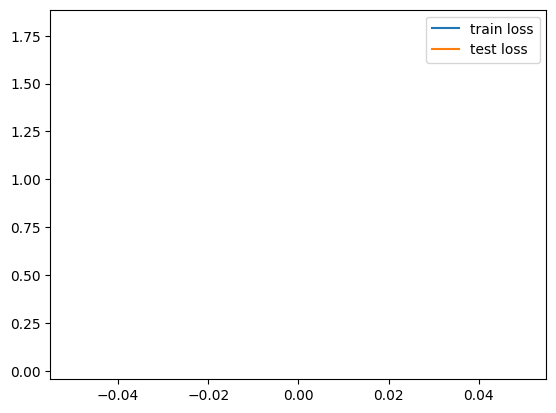

In [31]:
#plot train val loss
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [38]:
#visualize some predictions
for i in range(len(test_img)):
  img, mask = test_img[i], test_mask[i]
  img = img.unsqueeze(0).to(device)
  mask = mask.unsqueeze(0).to(device)
  logits = vit_3d_seg(img)
  pred_mask = vit_3d_seg.logits_to_mask(logits)
  save_gif(pred_mask, f"pred_mask{i}.gif")
  save_gif(mask, f"gt_mask{i}.gif")

AttributeError: 'SimpleViT3dSeg' object has no attribute 'logits_to_mask'